In [1]:
import numpy as np
from matplotlib import pyplot as plt
import xir
import vart
import time 

class coreDPU:
    def __init__(self,model_path):
        g = xir.Graph.deserialize(model_path)
        sub = []
        root = g.get_root_subgraph()

        child_subgraph = root.toposort_child_subgraph()
        sub = [s for s in child_subgraph
              if s.has_attr("device") and s.get_attr("device").upper() == "DPU"]
        self.model = sub
        self.__createDPU()
        
    def __createDPU(self):
        self.__dpu = vart.Runner.create_runner(self.model[0],"run")
        input_tensors = self.__dpu.get_input_tensors() #得模型DPU輸入層
        output_tensors = self.__dpu.get_output_tensors() #得模型運算DPU最終層
        self.__input_dims = tuple(input_tensors[0].dims) #(1,224,224,3)
        self.__output_dims = tuple(output_tensors[0].dims) #(1,6)
       
    def runDPU(self,img):
        input_data = []
        output_data = []
        input_data = [np.empty(self.__input_dims, dtype =np.float32, order = "C")]
        output_data = [np.empty(self.__output_dims, dtype = np.float32, order = "C")]
        dpu_image = input_data[0]
        dpu_image[0,...] =  img[0] #圖進DPU的BUFFER,
        #print(np.shape(img[0]))
        #print(np.shape(img))
        #im_plt = cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB)
        #plt.imshow(im_plt)
        #plt.show()
        #time.sleep(5)
        #print(np.shape(input_data))
        dpu_sync = self.__dpu.execute_async(dpu_image,output_data)
        self.__dpu.wait(dpu_sync)
        ans = np.argmax(output_data[0]) +1#分類
        #print(output_data[0])
        #print('AQI_LEVEL:' + str(ans+1))
        return output_data[0]

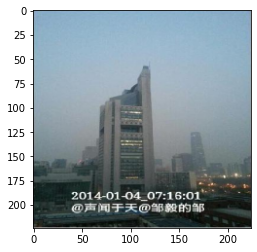

(1, 224, 224, 3)
8.903520345687866
0.053162574768066406
AQI_LEVEL: [[-4.25  0.25  1.    4.   -2.   -3.25]]


In [2]:
##run DPU Demo
import cv2
from matplotlib import pyplot as plt
image_path = "2014_01_04_0716.jpg"
model_path = "KV260_4096.xmodel"

try:
    image = cv2.imread(image_path)
    #print(image)
    image_resize = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
    im_plt = cv2.cvtColor(image_resize, cv2.COLOR_BGR2RGB)
    plt.imshow(im_plt)
    plt.show()
except Exception as a:
    print(a)
time1 = time.time()
DPU_Class = coreDPU(model_path)
time2 = time.time()
image_list = im_plt[np.newaxis,:,:,:]
print(np.shape(image_list))
level = DPU_Class.runDPU(image_list)
time3 = time.time()
print(time2-time1)
print(time3-time2)
ans = np.argmax(level[0]) +1
print('AQI_LEVEL:',level)


In [ ]:
import subprocess
import json
# 執行 `ls` 指令
result = subprocess.run(["xdputil","query"], stdout=subprocess.PIPE)

# 將輸出轉換成字串
output = result.stdout.decode('utf-8')
json_object = json.loads(output)
print(type(json_object))
print(json_object["kernels"][0]["DPU Arch"])
# 顯示輸出

In [4]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

In [7]:
start = time.time()

explanation = explainer.explain_instance(im_plt, DPU_Class.runDPU,  
                                         top_labels=1,batch_size=1, hide_color=0,num_samples=200)
end = time.time()

  0%|          | 0/200 [00:00<?, ?it/s]

In [8]:
print(end-start)

17.84655475616455


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

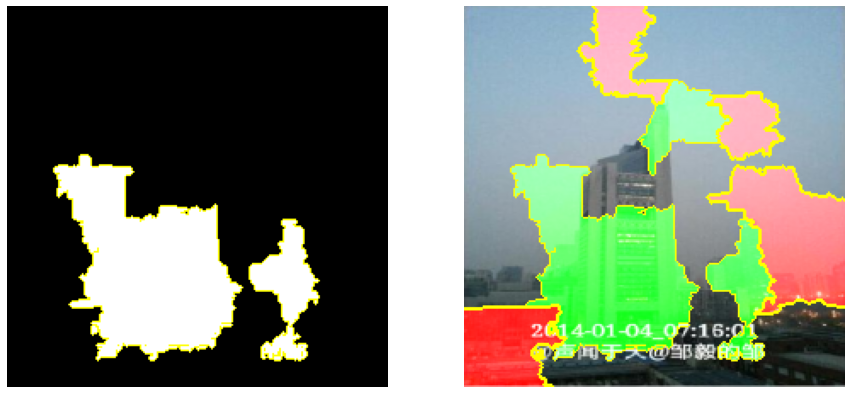

In [9]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
#ax2.imshow(mark_boundaries(cv2.cvtColor(temp_2, cv2.COLOR_BGR2RGB), mask_2))
ax1.axis('off')
ax2.axis('off')